# Automotive glass price prediction model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime as dt

In [2]:
#Loading the dataset
df = pd.read_excel('price_prediction.xlsx')

### Understanding the dataset

In [3]:
df.head()

,ЕврокодПолный,Модель название,Модель,Тип стекла,ЦветСтекла,ЦветПолосы,Тип кузова,МестоСтекла,Характеристики,Модификации,Расширение,Остаток,ПродажиГод,Дил Цена USD
0,0001AGNBLV-01,Chevrolet Lumina APV,1,A,GN,BL,NaN,NaN,V,NaN,1,2.0,NaN,97.52
1,0002AGNBLV-01,Pontiac Trans Sport,2,A,GN,BL,NaN,NaN,V,NaN,1,NaN,NaN,97.52
2,0003AGNBLV-01,Oldsmobile Silhouette,3,A,GN,BL,NaN,NaN,V,NaN,1,NaN,NaN,97.52
3,0001LGNV5FD-01,Chevrolet Lumina APV,1,L,GN,NaN,V5,FD,NaN,NaN,1,NaN,NaN,43.61
4,0002LGNV5FD-01,Pontiac Trans Sport,2,L,GN,NaN,V5,FD,NaN,NaN,1,NaN,NaN,43.61


In [4]:
df = df.rename(columns={'ЕврокодПолный' : 'item', 'Модель название' : 'model_name', 'Модель' : 'model', \
                  'Тип стекла' : 'glass_type', 'ЦветСтекла': 'glass_color', 'ЦветПолосы' : 'top_color', \
                  'Тип кузова' : 'body_type', 'МестоСтекла': 'glass_place', 'Характеристики' : 'characteristics', \
                  'Модификации' : 'modifications', 'Расширение' : 'brand', 'Остаток' : 'stock', 'ПродажиГод' : 'sales', \
                  'Дил Цена USD' : 'price'
                 })

In [5]:
df.shape

(10354, 14)

In [6]:
df.isnull().sum().sort_values()

item                  0
model_name            0
model                 0
glass_type            0
glass_color           0
brand                 0
price               880
body_type          4346
stock              4956
glass_place        5590
characteristics    5620
sales              6308
top_color          8420
modifications      8579
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10354 entries, 0 to 10353
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   item             10354 non-null  object 
 1   model_name       10354 non-null  object 
 2   model            10354 non-null  int64  
 3   glass_type       10354 non-null  object 
 4   glass_color      10354 non-null  object 
 5   top_color        1934 non-null   object 
 6   body_type        6008 non-null   object 
 7   glass_place      4764 non-null   object 
 8   characteristics  4734 non-null   object 
 9   modifications    1775 non-null   object 
 10  brand            10354 non-null  int64  
 11  stock            5398 non-null   float64
 12  sales            4046 non-null   float64
 13  price            9474 non-null   float64
dtypes: float64(3), int64(2), object(9)
memory usage: 1.1+ MB


In [8]:
df.describe()

,model,brand,stock,sales,price
count,10354.000000,10354.000000,5398.000000,4046.000000,9474.000000
mean,746.872996,2.256906,7.232308,10.030895,59.135109
std,432.616092,1.450381,20.706176,39.785435,55.069963
min,1.000000,1.000000,1.000000,-1.000000,0.200000
25%,358.000000,2.000000,1.000000,1.000000,19.130000
50%,767.000000,2.000000,3.000000,2.000000,48.360000
75%,1127.750000,2.000000,6.000000,5.000000,81.610000
max,1527.000000,14.000000,428.000000,1055.000000,1115.170000


### Data preprocessing

In [9]:
df = df.drop(['stock', 'sales'], axis=1)

In [10]:
tr_df = pd.DataFrame(df['price'])
df = df.drop(['item', 'model_name', 'price'], axis=1)

In [11]:
df = df.fillna(0)

In [12]:
characteristics = ''.join(str(e) for e in list(df.characteristics.unique()))

In [13]:
characteristics = sorted(list(set(characteristics)))

In [14]:
n = pd.DataFrame(index=range(df.shape[0]), columns=characteristics)

In [15]:
for i in range(len(df['characteristics'])):
    for j in range(len(str(df['characteristics'][i]))):        
        a = str(df['characteristics'][i])[j]
        n[a][i] = 1

In [16]:
n = n.fillna(0)

In [17]:
tr_df = tr_df.fillna(tr_df['price'].mean())

In [18]:
df = df.merge(n, left_index=True, right_index=True)

In [19]:
df = df.merge(tr_df, left_index=True, right_index=True)

In [20]:
df = df.drop('characteristics', axis=1)

In [21]:
modl = pd.get_dummies(df.model)
modl.columns = ['model' + str(col) for col in modl.columns]
df = df.join(modl)
df = df.drop('model', axis=1)

In [22]:
glass_typ = pd.get_dummies(df.glass_type)
glass_typ.columns = ['glass_type' + str(col) for col in glass_typ.columns]
df = df.join(glass_typ)
df = df.drop('glass_type', axis=1)

In [23]:
glass_col = pd.get_dummies(df.glass_color)
glass_col.columns = ['glass_color' + str(col) for col in glass_col.columns]
df = df.join(glass_col)
df = df.drop('glass_color', axis=1)

In [24]:
top_col = pd.get_dummies(df.top_color)
top_col.columns = ['top_color' + str(col) for col in top_col.columns]
df = df.join(top_col)
df = df.drop('top_color', axis=1)

In [25]:
body_t = pd.get_dummies(df.body_type)
body_t.columns = ['body_type' + str(col) for col in body_t.columns]
df = df.join(body_t)
df = df.drop('body_type', axis=1)

In [26]:
glass_p = pd.get_dummies(df.glass_place)
glass_p.columns = ['glass_place' + str(col) for col in glass_p.columns]
df = df.join(glass_p)
df = df.drop('glass_place', axis=1)

In [27]:
modif = pd.get_dummies(df.modifications)
modif.columns = ['modifications' + str(col) for col in modif.columns]
df = df.join(modif)
df = df.drop('modifications', axis=1)

In [28]:
brd = pd.get_dummies(df.brand)
brd.columns = ['brand' + str(col) for col in brd.columns]
df = df.join(brd)
df = df.drop('brand', axis=1)

### Building a regression model

In [29]:
#do not use because of calculation time
#df.corr()

In [30]:
#do not use because of calculation time
#price_corr = df.corr()['price'].apply(abs).sort_values()
#price_corr

In [31]:
X_LassoCV = df.drop('price', axis=1)
y_LassoCV = df['price']

In [32]:
#L1-regularization
reg = LassoCV()
reg.fit(X_LassoCV, y_LassoCV)
print("Best score using built-in LassoCV: %f" % reg.score(X_LassoCV, y_LassoCV))

Best score using built-in LassoCV: 0.723669


In [33]:
coef = pd.Series(reg.coef_, index = X_LassoCV.columns)
best_features = sum(coef != 0)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 198 variables and eliminated the other 1545 variables


In [34]:
imp_coef = coef.apply(abs).sort_values()
features = imp_coef[-best_features:].index
features = list(features)

In [35]:
new_df = df[features]
new_df = new_df.merge(tr_df, left_index=True, right_index=True)
new_df.head()

,model78,glass_colorGD,body_typeL2,body_typeH,model705,model961,modifications1H,glass_colorBS,model641,model342,...,U,model594,model73,modifications2T,glass_colorCD,model939,glass_colorGC,model917,model1365,price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,97.52
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,97.52
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,97.52
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43.61
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43.61


<AxesSubplot:>

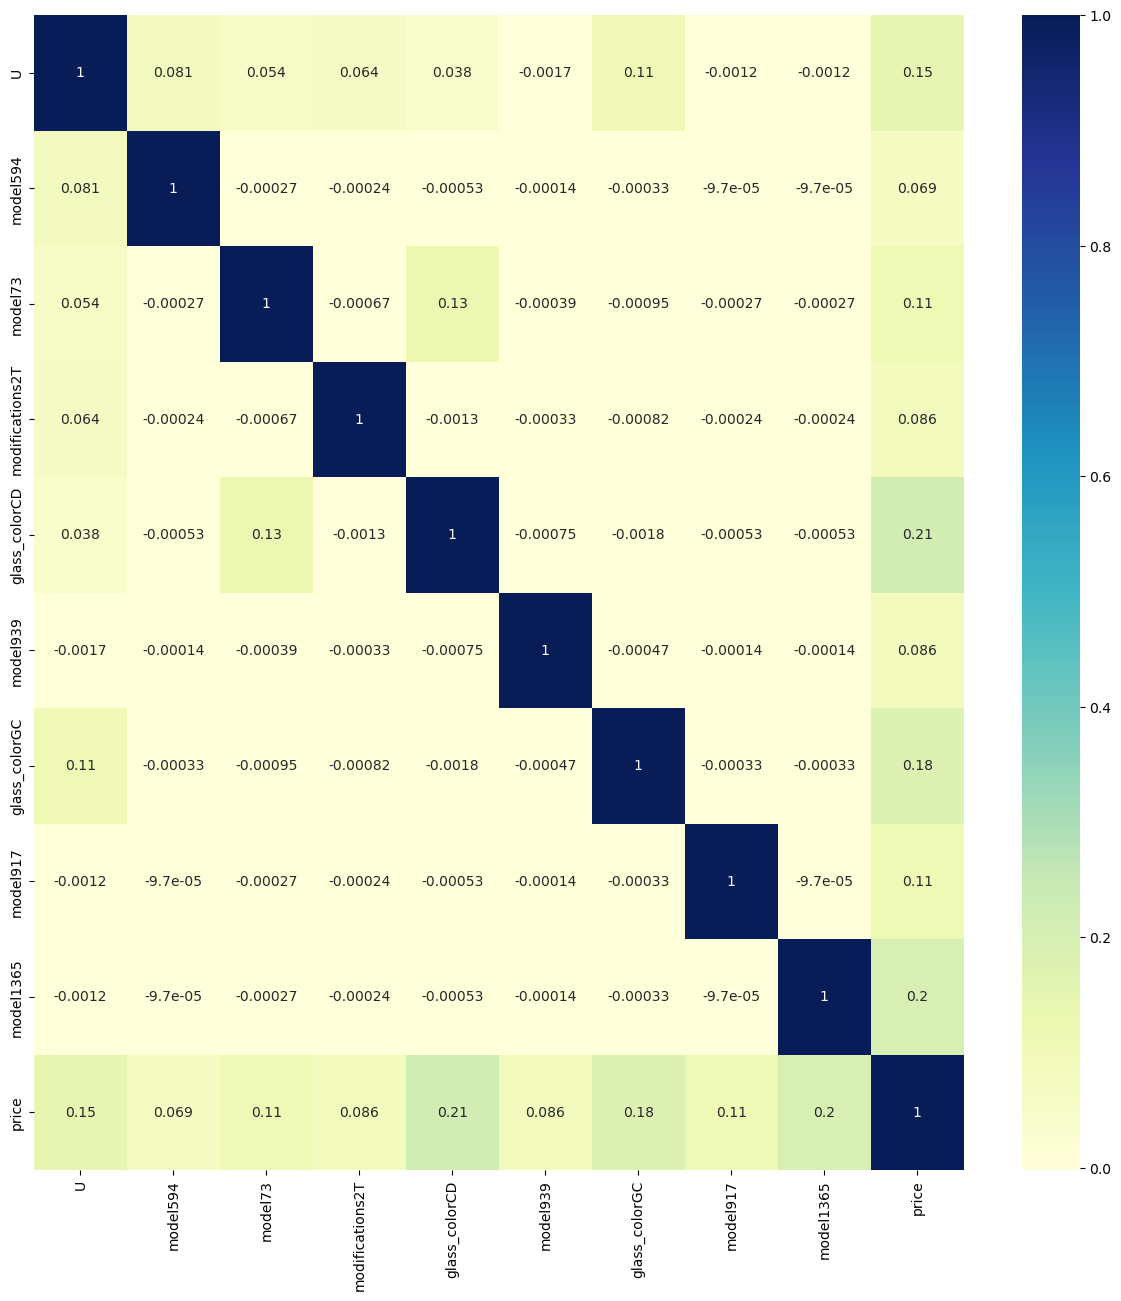

In [36]:
# just sample of heatmap correlation of top-10 features
plt.figure(figsize=(15, 15))
sns.heatmap(new_df.iloc[:,-10:].corr(), annot=True, cmap='YlGnBu')

In [37]:
X = new_df.drop('price', axis=1)
y = new_df['price']
SEED=100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [38]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_LassoCV)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Model evaluation

In [39]:
rf_model = RandomForestRegressor(random_state=SEED, n_estimators=1000, n_jobs=-1)

In [40]:
start = dt.now()
rf_model.fit(X_train_sc, y_train)
rf_model.score(X_test_sc, y_test)
running_secs = (dt.now() - start).seconds
print('Time of evaluation model is:', round(running_secs/60, 2), ' m')

Time of evaluation model is: 0.68  m


### Model prediction

In [41]:
y_pred = rf_model.predict(X_test_sc)
rf_model.score(X_test_sc, y_test)

0.7235086843625622

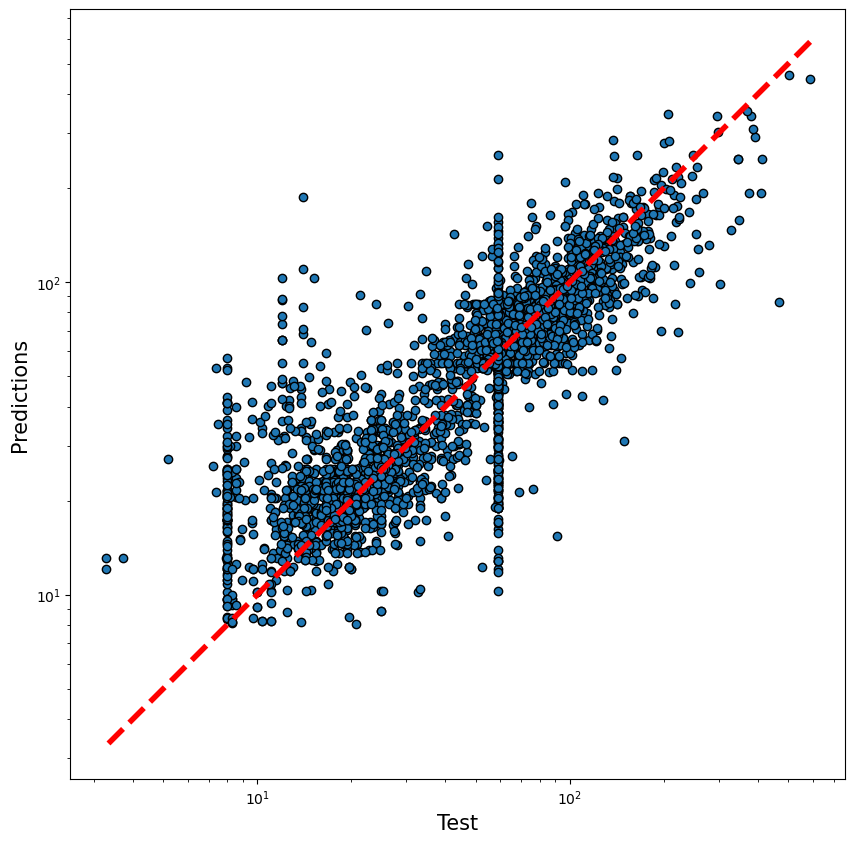

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r--', lw=4)
plt.xlabel('Test', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [43]:
y_test.iloc[0]

65.58

In [44]:
round(y_pred[0], 2)

66.2